In [1]:
#This notebook models the monthly sunspot data

In [2]:
import pandas as pd
import numpy as np
import scipy as py

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['savefig.dpi'] = 144
plt.rcParams['figure.figsize'] = 14, 10

In [3]:
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [4]:
sunspots_day = pd.read_csv('SIDC-SUNSPOTS_D.csv')
sunspots_month = pd.read_csv('SIDC-SUNSPOTS_13.csv')

In [5]:
sunspots_month.Date = pd.to_datetime(sunspots_month.Date)
sunspots_month.index = sunspots_month.Date
sunspots_month.head()

,Date,13-Month Smoothed Total Sunspot Number,Monthly Mean Standard Deviation,Number of Observations,Definitive/Provisional Indicator
Date,,,,,
2017-07-31,2017-07-31,NaN,NaN,958.0,0.0
2017-06-30,2017-06-30,NaN,NaN,947.0,0.0
2017-05-31,2017-05-31,NaN,NaN,1020.0,0.0
2017-04-30,2017-04-30,NaN,NaN,831.0,0.0
2017-03-31,2017-03-31,NaN,NaN,1011.0,0.0


In [6]:
y = sunspots_month['13-Month Smoothed Total Sunspot Number']
y.dropna(inplace = True)
y.head()

Date
2017-01-31    27.9
2016-12-31    28.5
2016-11-30    29.9
2016-10-31    31.5
2016-09-30    33.2
Name: 13-Month Smoothed Total Sunspot Number, dtype: float64

In [7]:
X = [x for x in range(0, len(y))]

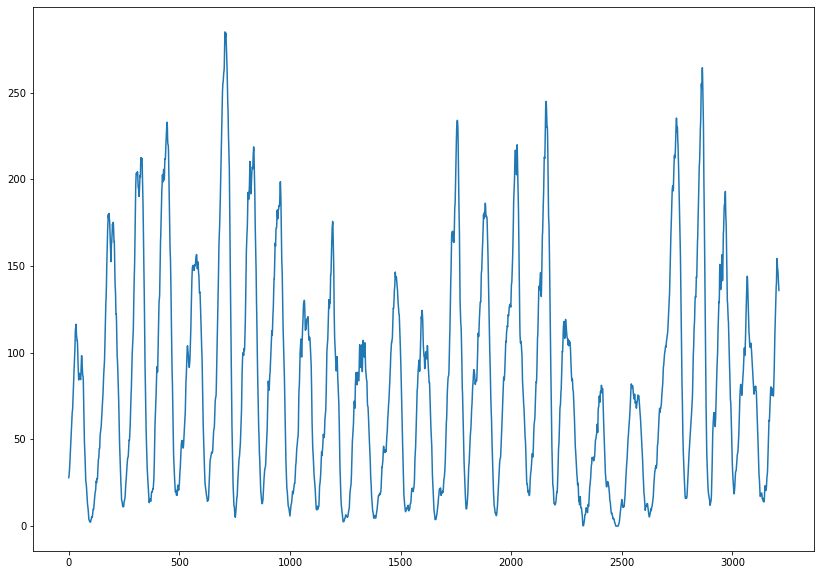

In [8]:
plt.plot(X, y)
plt.show()

In [9]:
#set random seed
np.random.seed(42)

In [10]:
scaler = MinMaxScaler()

In [11]:
mms_y = scaler.fit_transform(y.values.reshape(-1,1))

In [12]:
#split into train and test sets
train_size = int(len(mms_y) * 0.67)
test_size = len(mms_y) - train_size
train, test = mms_y[0:train_size,:], mms_y[train_size:len(mms_y),:]
print(len(train), len(test))

2151 1060


In [13]:
#simpler way than create_dataset?
def step_ahead(y, jump=1):
    y_current = y[:-(jump + 1), 0]
    y_next = y[jump:-1, 0]
    return np.reshape(y_current, (len(y_current), 1)), np.reshape(y_next, (len(y_next), 1))

In [14]:
#reshape into X=t and Y=t+1
look_back = 1
trainXb, trainYb = step_ahead(train, look_back)
testXb, testYb = step_ahead(test, look_back)

In [15]:
#reshape input to be [samples, time steps, features]
trainX = np.reshape(trainXb, (trainXb.shape[0], 1, trainXb.shape[1]))
testX = np.reshape(testXb, (testXb.shape[0], 1, testXb.shape[1]))

In [16]:
#create and fit the LSTM network
model = Sequential()
model.add(LSTM(256, input_shape=(1, look_back)))
model.add(Dense(1))

In [17]:
and_i_stop = EarlyStopping(monitor = 'loss', patience = 4, mode = 'auto')
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainYb, epochs=10, callbacks = [and_i_stop], batch_size=1, verbose=2)

Epoch 1/10
2149/2149 - 15s - loss: 0.0027 - 15s/epoch - 7ms/step
Epoch 2/10
2149/2149 - 11s - loss: 2.8839e-04 - 11s/epoch - 5ms/step
Epoch 3/10
2149/2149 - 10s - loss: 3.1363e-04 - 10s/epoch - 5ms/step
Epoch 4/10
2149/2149 - 7s - loss: 2.7079e-04 - 7s/epoch - 3ms/step
Epoch 5/10
2149/2149 - 6s - loss: 2.9621e-04 - 6s/epoch - 3ms/step
Epoch 6/10
2149/2149 - 6s - loss: 2.7369e-04 - 6s/epoch - 3ms/step
Epoch 7/10
2149/2149 - 6s - loss: 2.6796e-04 - 6s/epoch - 3ms/step
Epoch 8/10
2149/2149 - 7s - loss: 2.7283e-04 - 7s/epoch - 3ms/step
Epoch 9/10
2149/2149 - 6s - loss: 2.6133e-04 - 6s/epoch - 3ms/step
Epoch 10/10
2149/2149 - 6s - loss: 2.7848e-04 - 6s/epoch - 3ms/step


In [18]:
#make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
#invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainYb)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testYb)
#calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 4.12 RMSE
Test Score: 3.91 RMSE


In [19]:
#saving the model
model.save('sunspot_model_f')

INFO:tensorflow:Assets written to: sunspot_model_f/assets


INFO:tensorflow:Assets written to: sunspot_model_f/assets


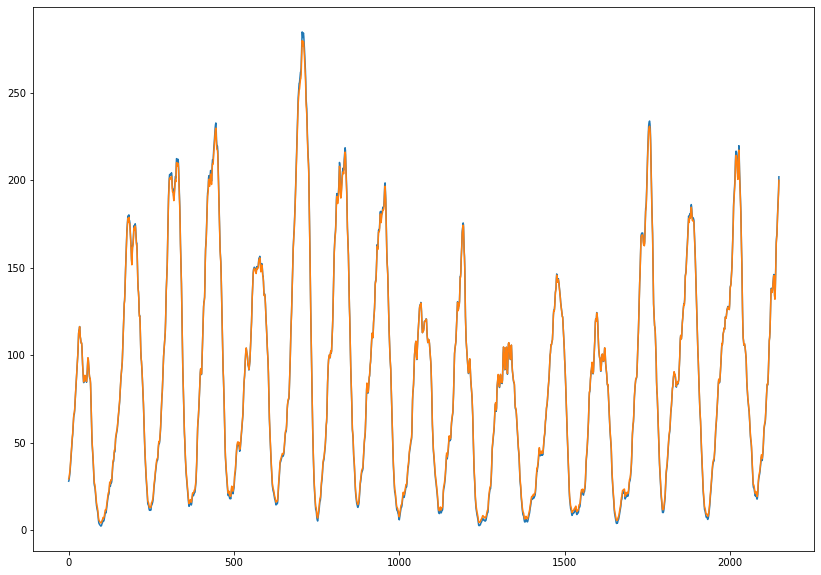

In [24]:
plt.plot(scaler.inverse_transform(mms_y[:len(trainPredict)]))
plt.plot(trainPredict)
plt.show()

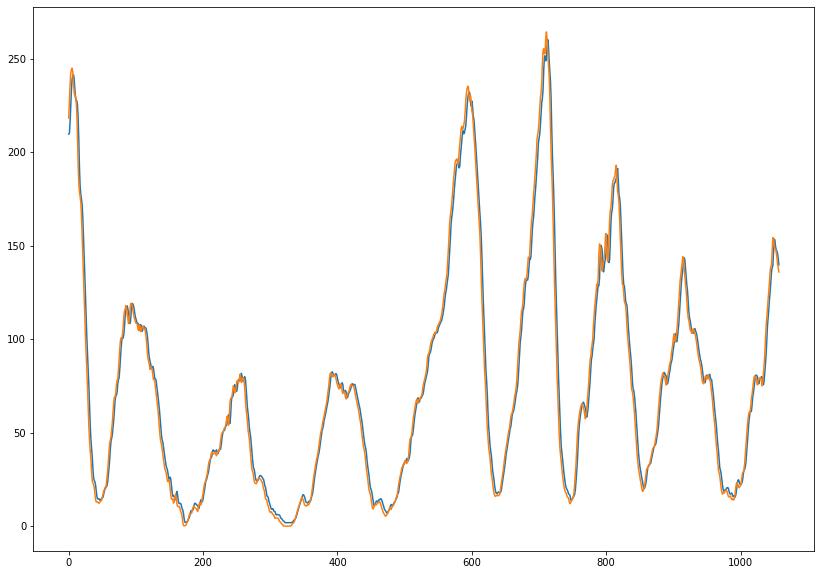

In [26]:
plt.plot(testPredict)
plt.plot(scaler.inverse_transform(mms_y[-len(testPredict):]))
plt.show()